In [1]:
#load and prep dataset 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the JSON file
json_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU-data-fra-github/data-jan-2022.json"
df = pd.read_json(json_path)

# Extract CPU values
cpu_data = [float(value[1]) for value in df['result'][0]['values']]
cpu_series = np.array(cpu_data)

# Split 80/20
split_index = int(len(cpu_series) * 0.8)
train = cpu_series[:split_index]
test = cpu_series[split_index:]

print(f"Total points: {len(cpu_series)} | Train: {len(train)} | Test: {len(test)}")


Total points: 4435 | Train: 3548 | Test: 887


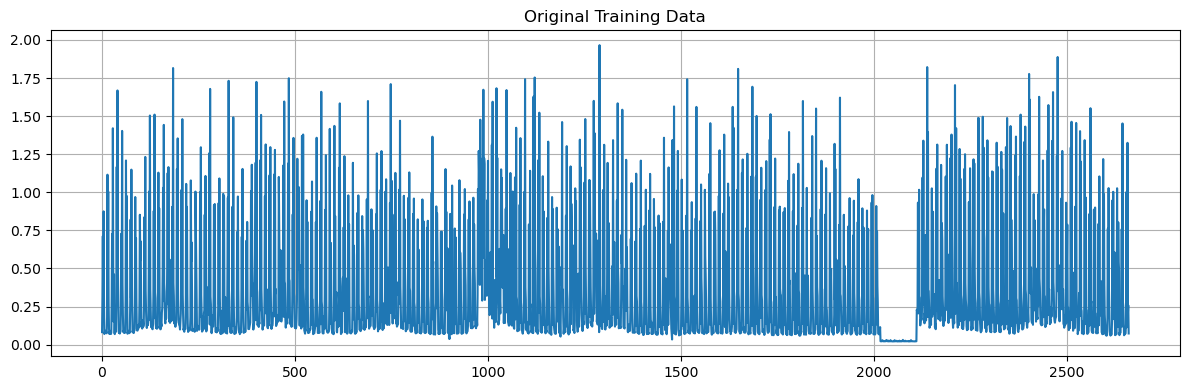

ADF Statistic (d=0): -5.132793758611503
p-value: 1.2039491660405129e-05
=> Stationary. Use d=0.

ADF Statistic (d=1): -13.768597333030222
p-value: 9.778252735907219e-26
=> Now stationary. Use d=1.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller

# Set your save directory
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Plot original training data
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.title("Original Training Data")
plt.grid(True)
plt.tight_layout()
plot_file = os.path.join(save_path, "Original_Training_Data.png")
plt.savefig(plot_file, bbox_inches='tight')
plt.show()

#ADF test on original data (d=0)
adf_result_0 = adfuller(train)
print("ADF Statistic (d=0):", adf_result_0[0])
print("p-value:", adf_result_0[1])
if adf_result_0[1] > 0.05:
    print("=> Not stationary. Try differencing (d=1).")
else:
    print("=> Stationary. Use d=0.")

#ADF test on differenced data (d=1)
diff_train = np.diff(train, n=1)
adf_result_1 = adfuller(diff_train)
print("\nADF Statistic (d=1):", adf_result_1[0])
print("p-value:", adf_result_1[1])
if adf_result_1[1] > 0.05:
    print("=> Still not stationary. Try d=2.")
else:
    print("=> Now stationary. Use d=1.")


<Figure size 1200x400 with 0 Axes>

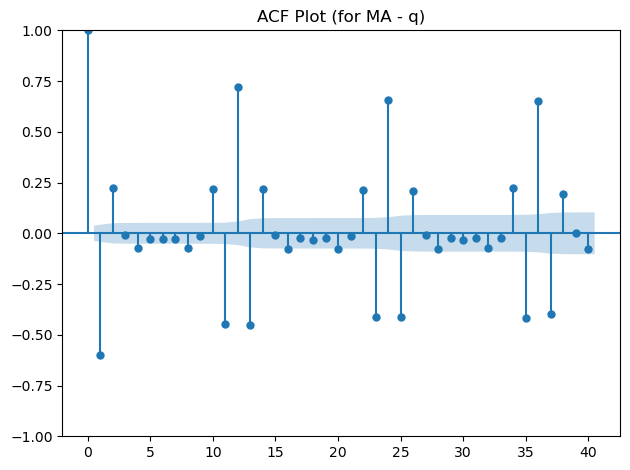

<Figure size 1200x400 with 0 Axes>

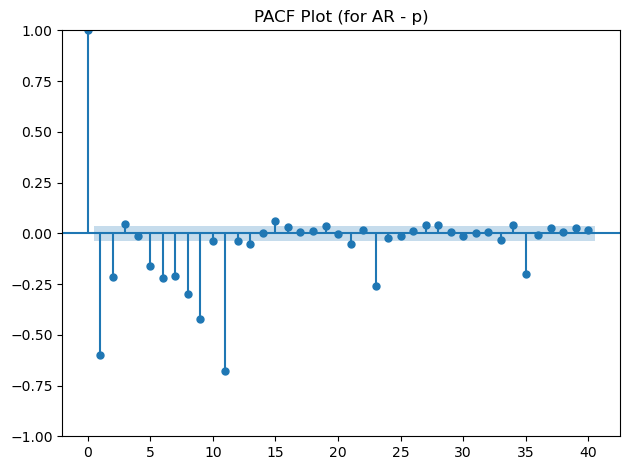


Suggested q (from ACF): 1
Suggested p (from PACF): 1

✅ Plots saved to: /Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np
import os

# Set your save directory
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Use the differenced series (if d=1)
d = 1  # Set this manually if you've already chosen d
series_for_acf_pacf = np.diff(train, n=d) if d > 0 else train

# Plot and Save ACF (for q) for deciding
plt.figure(figsize=(12, 4))
plot_acf(series_for_acf_pacf, lags=40)
plt.title("ACF Plot (for MA - q)")
plt.tight_layout()
acf_file = os.path.join(save_path, "ACF_Plot_for_MA_q.png")
plt.savefig(acf_file, bbox_inches='tight')
plt.show()

#  Plot and Save PACF (for p) for deciding
plt.figure(figsize=(12, 4))
plot_pacf(series_for_acf_pacf, lags=40)
plt.title("PACF Plot (for AR - p)")
plt.tight_layout()
pacf_file = os.path.join(save_path, "PACF_Plot_for_AR_p.png")
plt.savefig(pacf_file, bbox_inches='tight')
plt.show()

# Auto-suggests p and q based on significant spikes  just incase
threshold = 1.96 / np.sqrt(len(series_for_acf_pacf))

acf_vals = acf(series_for_acf_pacf, nlags=40)
pacf_vals = pacf(series_for_acf_pacf, nlags=40)

suggested_q = next((i for i, val in enumerate(acf_vals[1:], start=1) if abs(val) > threshold), 0)
suggested_p = next((i for i, val in enumerate(pacf_vals[1:], start=1) if abs(val) > threshold), 0)

print(f"\nSuggested q (from ACF): {suggested_q}")
print(f"Suggested p (from PACF): {suggested_p}")
print(f"\n✅ Plots saved to: {save_path}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3548
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1591.340
Date:                Mon, 14 Apr 2025   AIC                           3190.681
Time:                        03:57:53   BIC                           3215.377
Sample:                             0   HQIC                          3199.489
                               - 3548                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3500      0.016     21.298      0.000       0.318       0.382
ar.L1          0.5217      0.104      5.027      0.000       0.318       0.725
ma.L1         -0.4016      0.117     -3.432      0.0

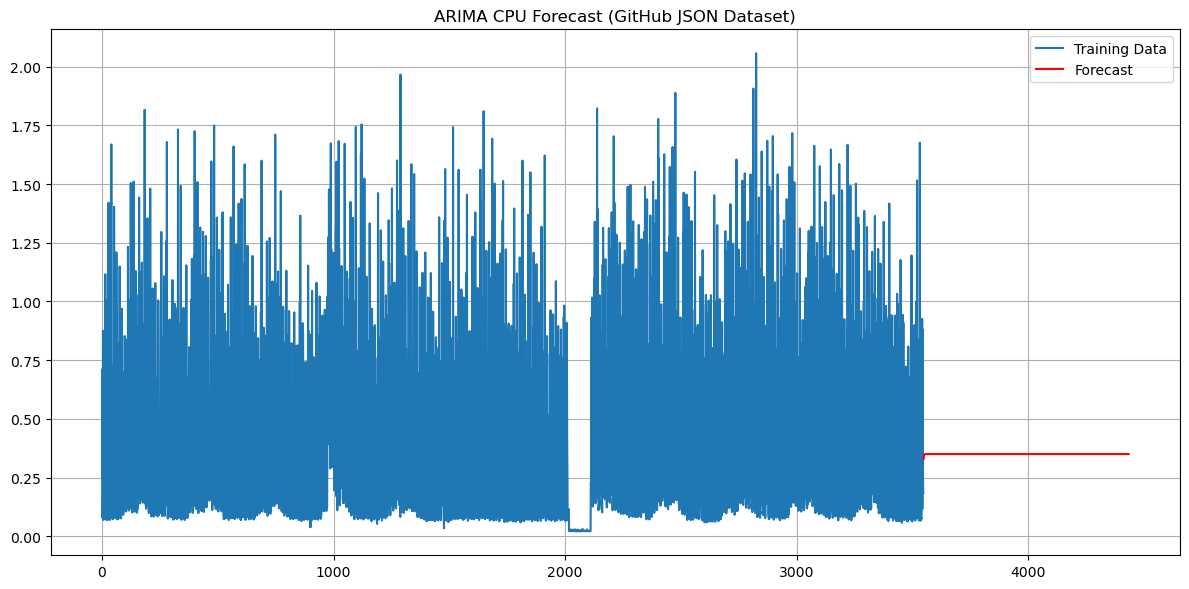

MAE:   0.2763
MSE:   0.1331
RMSE:  0.3649
PMAPE: 172.42%


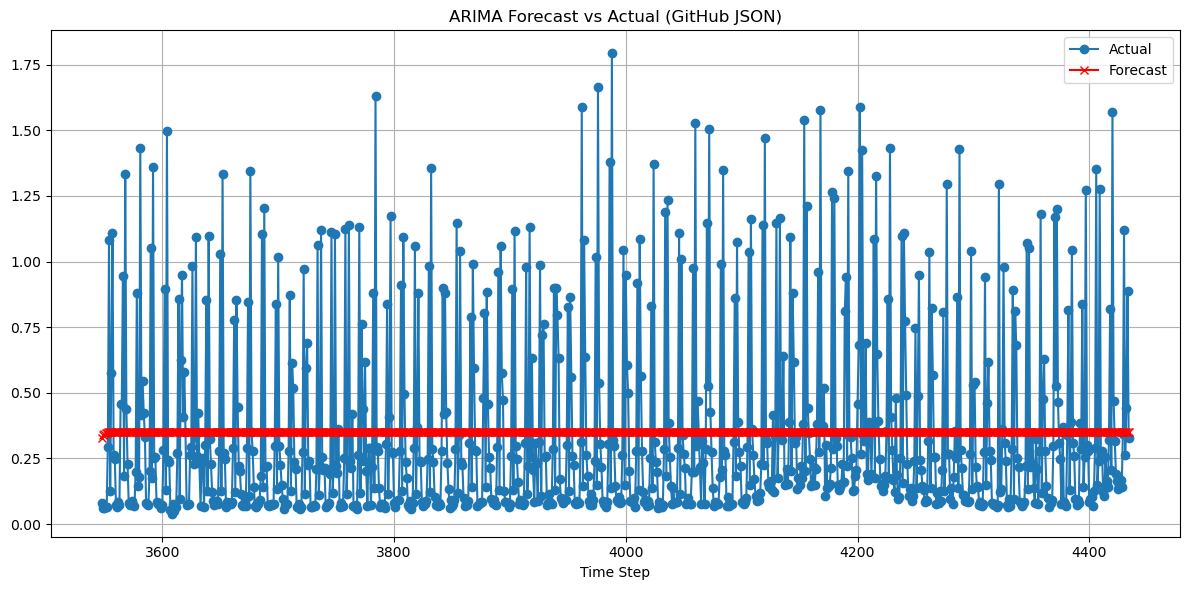

In [ ]:
#PMAPE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Save directory for plots
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Custom Penalized MAPE function
def penalized_mape(y_true, y_pred, penalty=2.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    percentage_error = penalized_error / np.maximum(np.abs(y_true), 1e-8)
    return np.mean(percentage_error) * 100

# Load data from JSON
json_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU-data-fra-github/data-jan-2022.json"
df = pd.read_json(json_path)

# Extract CPU values
cpu_data = [float(value[1]) for value in df['result'][0]['values']]
cpu_series = np.array(cpu_data)

# Split into training and test (80/20)
split_index = int(len(cpu_series) * 0.8)
train = cpu_series[:split_index]
test = cpu_series[split_index:]

#  Set ARIMA parameters based on ACF/PACF
p = 1
d = 0
q = 1

#  Fit ARIMA model
model = ARIMA(train, order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())

#  Forecast
forecast = fitted_model.forecast(steps=len(test))

#  Plot forecast vs training data
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(range(len(train), len(train) + len(test)), forecast, label="Forecast", color='red')
plt.legend()
plt.title("ARIMA CPU Forecast (GitHub JSON Dataset)")
plt.grid(True)
plt.tight_layout()
forecast_plot_path = os.path.join(save_path, "ARIMA_CPU_Forecast_vs_Training.png")
plt.savefig(forecast_plot_path, bbox_inches='tight')
plt.show()

# Evaluation
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
pmape = penalized_mape(test, forecast, penalty=2.0)

print(f"MAE:   {mae:.4f}")
print(f"MSE:   {mse:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"PMAPE: {pmape:.2f}%")

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(range(len(train), len(train) + len(test)), test, label='Actual', marker='o')
plt.plot(range(len(train), len(train) + len(test)), forecast, label='Forecast', marker='x', color='red')
plt.title("ARIMA Forecast vs Actual (GitHub JSON)")
plt.xlabel("Time Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
actual_vs_forecast_path = os.path.join(save_path, "ARIMA_Actual_vs_Forecast.png")
plt.savefig(actual_vs_forecast_path, bbox_inches='tight')
plt.show()


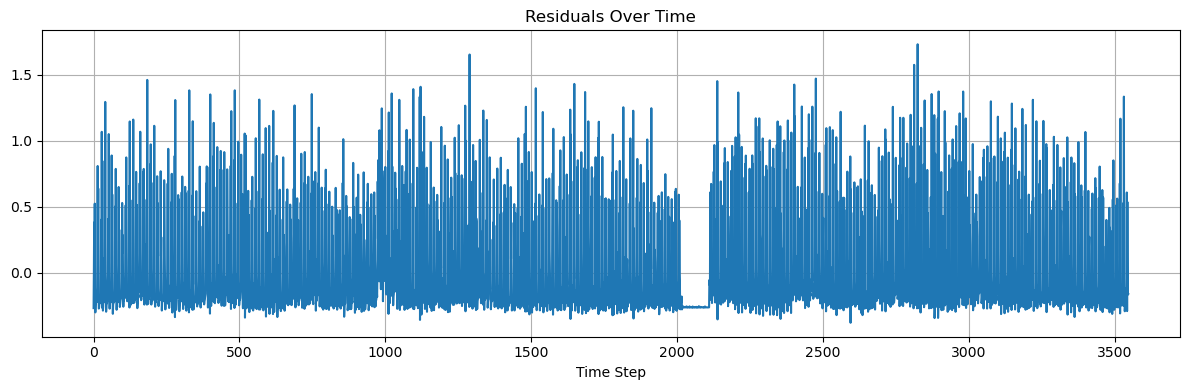

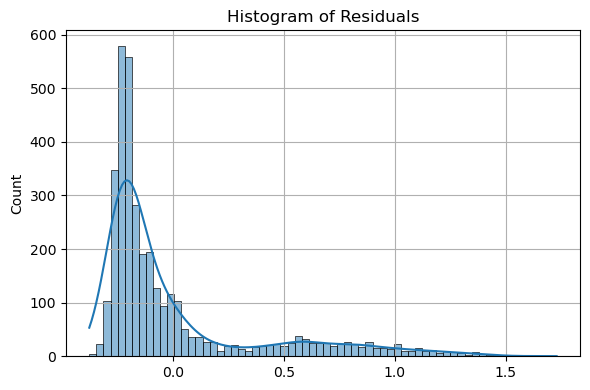

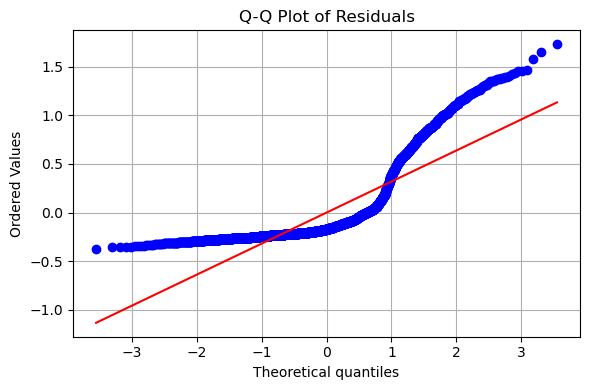

<Figure size 1200x400 with 0 Axes>

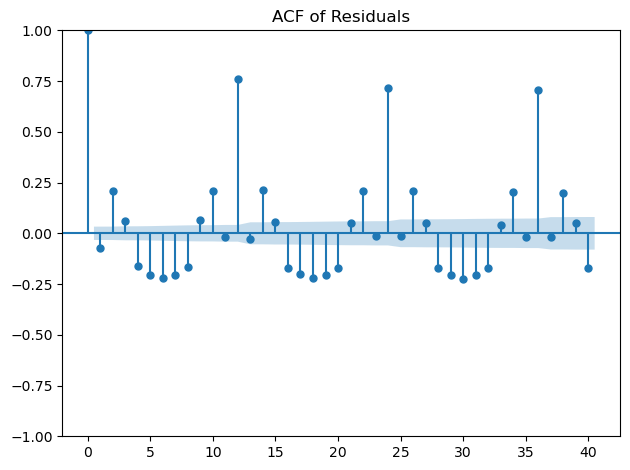

In [ ]:
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import os

# Save directory
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Get residuals
residuals = fitted_model.resid

# Plot residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.xlabel("Time Step")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "Residuals_Over_Time.png"), bbox_inches='tight')
plt.show()

# Histogram + KDE
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "Histogram_of_Residuals.png"), bbox_inches='tight')
plt.show()

#  Q-Q plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "QQ_Plot_of_Residuals.png"), bbox_inches='tight')
plt.show()

#ACF of residuals
plt.figure(figsize=(12, 4))
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.tight_layout()
plt.savefig(os.path.join(save_path, "ACF_of_Residuals.png"), bbox_inches='tight')
plt.show()



=== Forecast from 60% training ===

=== Forecast from 60% training ===
MAE:   0.2443
MSE:   0.1684
MAPE:  75.43%
PMAPE: 100.93%

=== Forecast from 75% training ===

=== Forecast from 75% training ===
MAE:   0.2489
MSE:   0.1335
MAPE:  123.43%
PMAPE: 139.95%

=== Forecast from 80% training ===

=== Forecast from 80% training ===
MAE:   0.2433
MSE:   0.1401
MAPE:  108.89%
PMAPE: 127.20%


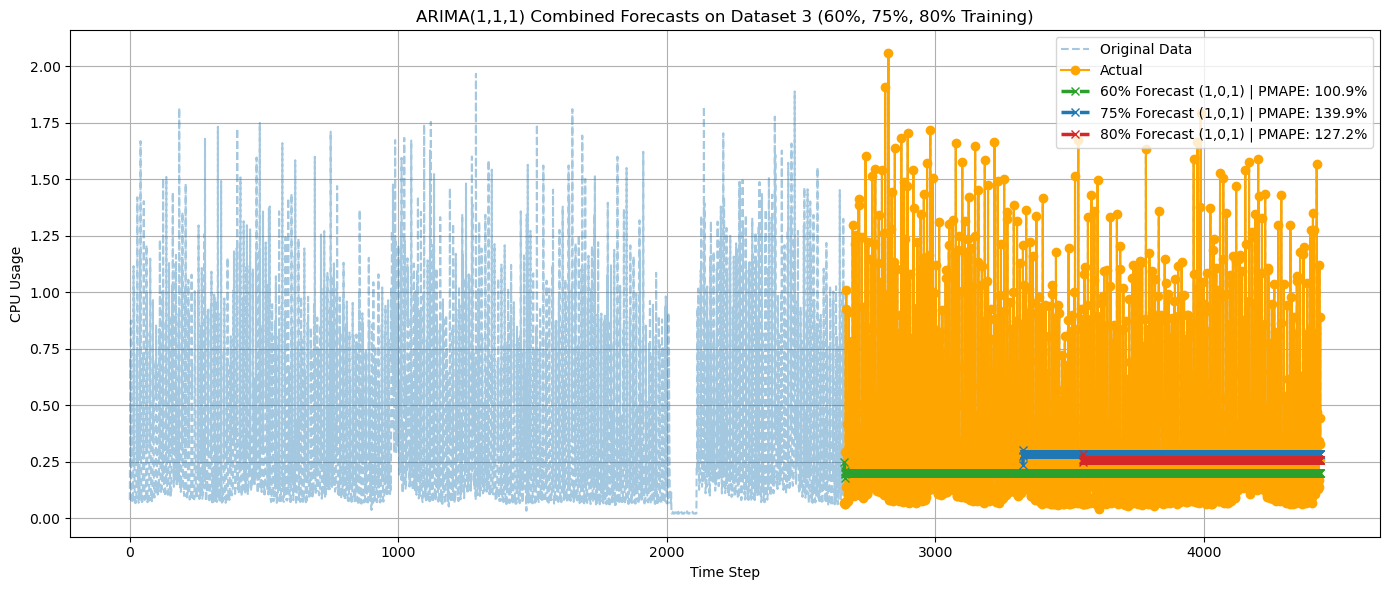

In [ ]:
#manuell arima 1.1.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# File paths
json_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU-data-fra-github/data-jan-2022.json"
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Load dataset 
df = pd.read_json(json_path)
cpu_data = [float(value[1]) for value in df['result'][0]['values']]
cpu_series = np.array(cpu_data)

# Penalized MAPE 
def penalized_mape(y_true, y_pred, penalty=2.0):
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    return np.mean(penalized_error / np.maximum(np.abs(y_true), 1e-8)) * 100

# ARIMA configuration 
p, d, q = 1, 1, 1
splits = {
    0.6: 'tab:green',
    0.75: 'tab:blue',
    0.8: 'tab:red'
}

# Store results for combined plot
forecast_results = {}

# Loop through training splits
for split, color in splits.items():
    split_index = int(len(cpu_series) * split)
    train = cpu_series[:split_index]
    test = cpu_series[split_index:]

    print(f"\n=== Forecast from {int(split * 100)}% training ===")
    try:
        model = ARIMA(train, order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test))

        # Evaluation metrics 
        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        pmape = penalized_mape(test, forecast)

        forecast_results[split] = {
            "forecast": forecast,
            "split_index": split_index,
            "pmape": pmape,
            "color": color
        }

        # Print metrics 
        print(f"\n=== Forecast from {int(split*100)}% training ===")
        print(f"MAE:   {mae:.4f}")
        print(f"MSE:   {mse:.4f}")
        print(f"MAPE:  {mape:.2f}%")
        print(f"PMAPE: {pmape:.2f}%")

        #  INDIVIDUAL PLOTS
        plt.figure(figsize=(14, 5))
        plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.3)
        plt.plot(range(split_index), train, label="Training Data", color='tab:blue')
        plt.plot(range(split_index, len(cpu_series)), test, label="Actual", color='orange', marker='o')
        plt.plot(range(split_index, len(cpu_series)), forecast,
                 label=f"Forecast (1,0,1) | PMAPE: {pmape:.1f}%",
                 color=color, linestyle='--', linewidth=2.5, marker='x')

        plt.title(f"ARIMA(1,1,1) Forecast vs Actual ({int(split * 100)}% Training)")
        plt.xlabel("Time Step")
        plt.ylabel("CPU Usage")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        filename = f"ARIMA_111_Forecast_{int(split * 100)}_Training.png"
        plt.savefig(os.path.join(save_path, filename), dpi=300)
        plt.close()

    except Exception as e:
        print(f"❌ Forecast failed for split {int(split * 100)}%: {e}")

# COMBINED PLOT 
plt.figure(figsize=(14, 6))
plt.plot(cpu_series, label="Original Data", color='tab:blue', linestyle='--', alpha=0.4)

min_index = min([v['split_index'] for v in forecast_results.values()])
plt.plot(range(min_index, len(cpu_series)), cpu_series[min_index:], label="Actual", color='orange', marker='o', linewidth=1.5)

for split, result in forecast_results.items():
    x_range = range(result['split_index'], result['split_index'] + len(result['forecast']))
    label = f"{int(split*100)}% Forecast (1,0,1) | PMAPE: {result['pmape']:.1f}%"
    plt.plot(x_range, result['forecast'], label=label, color=result['color'], linestyle='--', linewidth=2.5, marker='x')

plt.title("ARIMA(1,1,1) Combined Forecasts on Dataset 3 (60%, 75%, 80% Training)")
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "ARIMA_111_Combined.png"), dpi=300)
plt.show()



=== Forecast from 60% training ===

=== Forecast from 60% training ===
MAE:   0.2758
MSE:   0.1440
MAPE:  142.15%
PMAPE: 156.15%

=== Forecast from 75% training ===

=== Forecast from 75% training ===
MAE:   0.2765
MSE:   0.1305
MAPE:  162.48%
PMAPE: 175.82%

=== Forecast from 80% training ===

=== Forecast from 80% training ===
MAE:   0.2763
MSE:   0.1331
MAPE:  159.01%
PMAPE: 172.42%


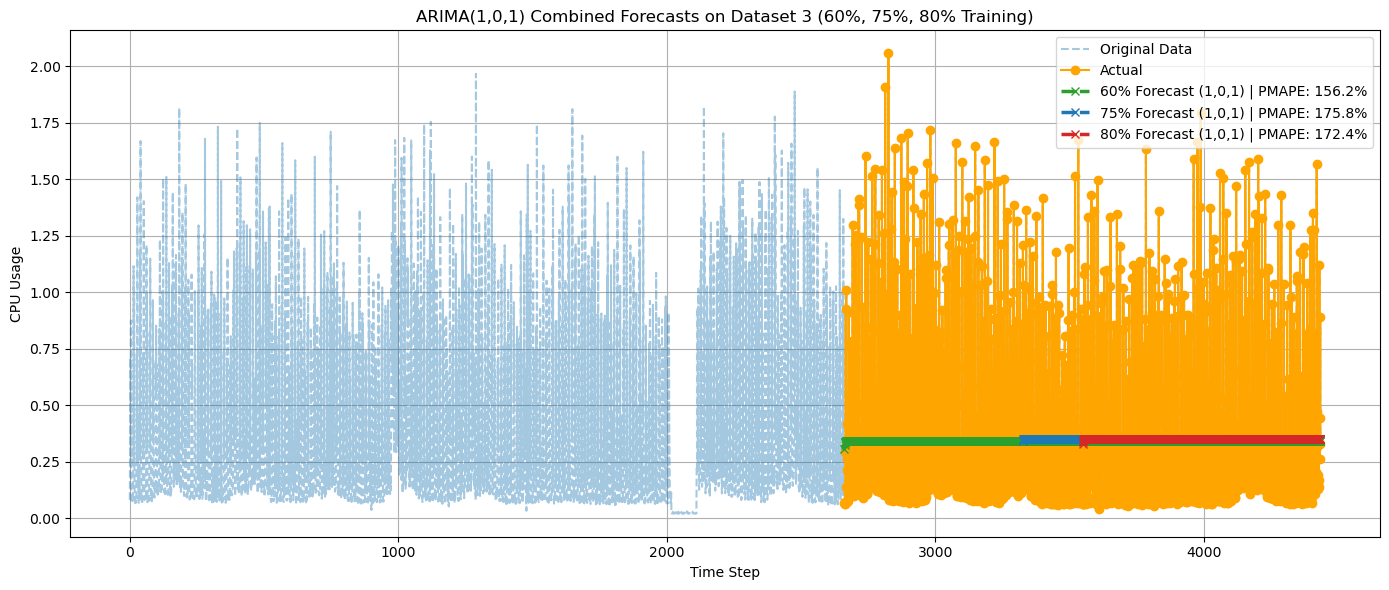

In [ ]:
#manuell arima for 1.0.1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# File paths 
json_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU-data-fra-github/data-jan-2022.json"
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Load dataset 
df = pd.read_json(json_path)
cpu_data = [float(value[1]) for value in df['result'][0]['values']]
cpu_series = np.array(cpu_data)

# Penalized MAPE 
def penalized_mape(y_true, y_pred, penalty=2.0):
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    return np.mean(penalized_error / np.maximum(np.abs(y_true), 1e-8)) * 100

# ARIMA configuration 
p, d, q = 1, 0, 1
splits = {
    0.6: 'tab:green',
    0.75: 'tab:blue',
    0.8: 'tab:red'
}

# Store results for combined plot
forecast_results = {}

# Loop through training splits
for split, color in splits.items():
    split_index = int(len(cpu_series) * split)
    train = cpu_series[:split_index]
    test = cpu_series[split_index:]

    print(f"\n=== Forecast from {int(split * 100)}% training ===")
    try:
        model = ARIMA(train, order=(p, d, q))
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test))

        # Evaluation metrics 
        mae = mean_absolute_error(test, forecast)
        mse = mean_squared_error(test, forecast)
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        pmape = penalized_mape(test, forecast)

        forecast_results[split] = {
            "forecast": forecast,
            "split_index": split_index,
            "pmape": pmape,
            "color": color
        }
        #Print metricss
        print(f"\n=== Forecast from {int(split*100)}% training ===")
        print(f"MAE:   {mae:.4f}")
        print(f"MSE:   {mse:.4f}")
        print(f"MAPE:  {mape:.2f}%")
        print(f"PMAPE: {pmape:.2f}%")

        # INDIVIDUAL PLOT 
        plt.figure(figsize=(14, 5))
        plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.3)
        plt.plot(range(split_index), train, label="Training Data", color='tab:blue')
        plt.plot(range(split_index, len(cpu_series)), test, label="Actual", color='orange', marker='o')
        plt.plot(range(split_index, len(cpu_series)), forecast,
                 label=f"Forecast (1,0,1) | PMAPE: {pmape:.1f}%",
                 color=color, linestyle='--', linewidth=2.5, marker='x')

        plt.title(f"ARIMA(1,0,1) Forecast vs Actual ({int(split * 100)}% Training)")
        plt.xlabel("Time Step")
        plt.ylabel("CPU Usage")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        filename = f"ARIMA_101_Forecast_{int(split * 100)}_Training.png"
        plt.savefig(os.path.join(save_path, filename), dpi=300)
        plt.close()

    except Exception as e:
        print(f"❌ Forecast failed for split {int(split * 100)}%: {e}")

# COMBINED PLOT 
plt.figure(figsize=(14, 6))
plt.plot(cpu_series, label="Original Data", color='tab:blue', linestyle='--', alpha=0.4)

min_index = min([v['split_index'] for v in forecast_results.values()])
plt.plot(range(min_index, len(cpu_series)), cpu_series[min_index:], label="Actual", color='orange', marker='o', linewidth=1.5)

for split, result in forecast_results.items():
    x_range = range(result['split_index'], result['split_index'] + len(result['forecast']))
    label = f"{int(split*100)}% Forecast (1,0,1) | PMAPE: {result['pmape']:.1f}%"
    plt.plot(x_range, result['forecast'], label=label, color=result['color'], linestyle='--', linewidth=2.5, marker='x')

plt.title("ARIMA(1,0,1) Combined Forecasts on Dataset 3 (60%, 75%, 80% Training)")
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "ARIMA_101_Combined.png"), dpi=300)
plt.show()



=== Forecast from 60% training ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2648.313, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3962.924, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2776.743, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2370.398, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3960.924, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2672.788, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2704.372, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2671.521, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2368.396, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2670.788, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2702.372, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2774.743, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2669.521, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 

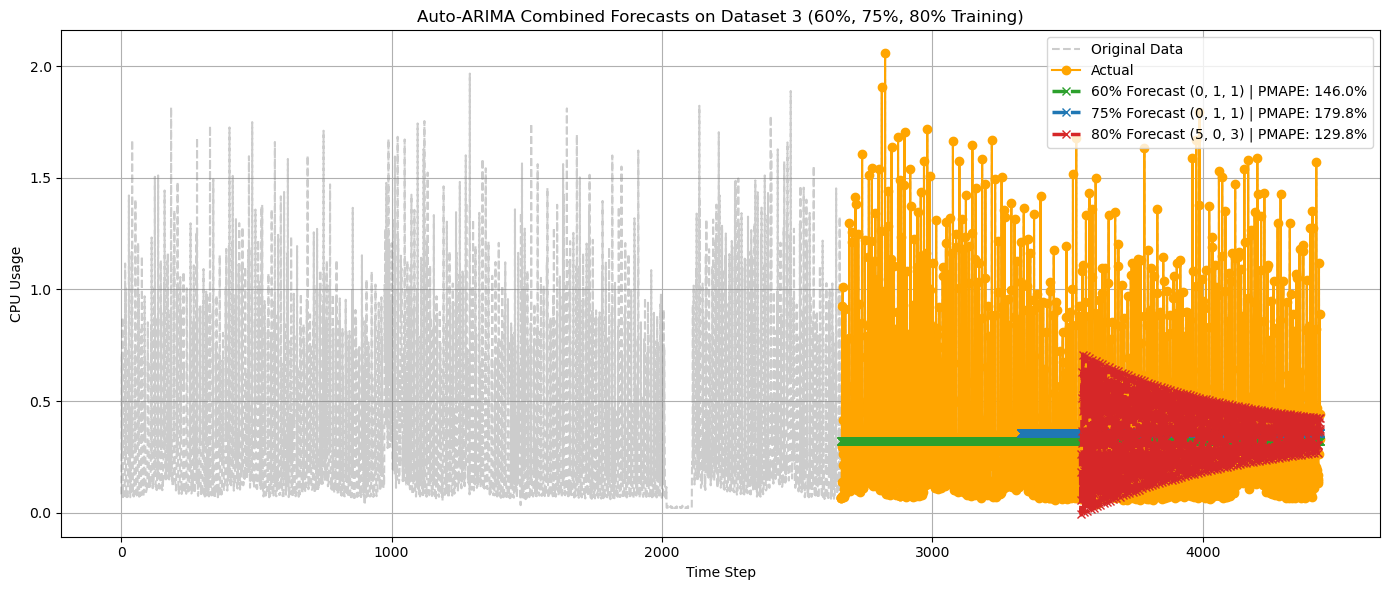

In [ ]:
# Auto-ARIMA Combined and induvidual Forecast Plot for Dataset 3 with PMAPE and Trace 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# Save path
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Load Dataset 3 (JSON) 
json_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU-data-fra-github/data-jan-2022.json"
df = pd.read_json(json_path)
cpu_data = [float(value[1]) for value in df['result'][0]['values']]
cpu_series = np.array(cpu_data)

#  Penalized MAPE 
def penalized_mape(y_true, y_pred, penalty=2.0):
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    return np.mean(penalized_error / np.maximum(np.abs(y_true), 1e-8)) * 100

# Training splits
splits = {
    0.6: 'tab:green',
    0.75: 'tab:blue',
    0.8: 'tab:red'
}

#  Store results for combined plot
combined_forecasts = {}

# Loop through each split
for split, color in splits.items():
    split_index = int(len(cpu_series) * split)
    train = cpu_series[:split_index]
    test = cpu_series[split_index:]

    print(f"\n=== Forecast from {int(split * 100)}% training ===")
    try:
        model = auto_arima(train,
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore',
                           trace=True)

        fitted_model = model.fit(train)
        forecast = fitted_model.predict(n_periods=len(test))

        # Metrics
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        pmape = penalized_mape(test, forecast, penalty=2.0)

        print(f"Best ARIMA order: {model.order}")
        print(f"MAE:   {mae:.4f}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"MAPE:  {mape:.2f}%")
        print(f"PMAPE: {pmape:.2f}%")

        # Save for combined
        combined_forecasts[split] = {
            'forecast': forecast,
            'split_index': split_index,
            'color': color,
            'pmape': pmape,
            'order': model.order
        }

        # INDIVIDUAL PLOT 
        plt.figure(figsize=(14, 5))
        plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.3)
        plt.plot(range(split_index), train, label="Training Data", color='tab:blue')
        plt.plot(range(split_index, len(cpu_series)), test, label="Actual", color='orange', marker='o')
        plt.plot(range(split_index, len(cpu_series)), forecast,
                 label=f"Forecast {model.order} | PMAPE: {pmape:.1f}%",
                 color=color, linestyle='--', linewidth=2.5, marker='x')

        plt.title(f"Auto-ARIMA Forecast vs Actual ({int(split * 100)}% Training)")
        plt.xlabel("Time Step")
        plt.ylabel("CPU Usage")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        filename = f"AutoARIMA_Forecast_{int(split * 100)}_Training.png"
        plt.savefig(os.path.join(save_path, filename), dpi=300)
        plt.close()

    except Exception as e:
        print(f"❌ Forecast failed for {int(split * 100)}%: {e}")

# COMBINED PLOT 
plt.figure(figsize=(14, 6))
plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.4)

# Actual values from earliest forecast split
min_split = min([v['split_index'] for v in combined_forecasts.values()])
plt.plot(range(min_split, len(cpu_series)), cpu_series[min_split:], 
         label="Actual", color='orange', marker='o', linewidth=1.5)

for split, result in combined_forecasts.items():
    x_range = range(result['split_index'], result['split_index'] + len(result['forecast']))
    plt.plot(x_range, result['forecast'],
             label=f"{int(split*100)}% Forecast {result['order']} | PMAPE: {result['pmape']:.1f}%",
             color=result['color'], linestyle='--', linewidth=2.5, marker='x')

plt.title("Auto-ARIMA Combined Forecasts on Dataset 3 (60%, 75%, 80% Training)")
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "AutoARIMA_Dataset3_Combined.png"), dpi=300)
plt.show()



=== Forecast from 90% training ===
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3737.386, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6032.813, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4929.229, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5463.628, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3738.300, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3904.182, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3727.576, Time=0.93 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3827.300, Time=0.64 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=6.28 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3293.463, Time=6.17 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3732.357, Time=2.82 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=3730.904, Time=2.72 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=3405.472, Time=7.90 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=3182.425, Time=6.25 sec
 A

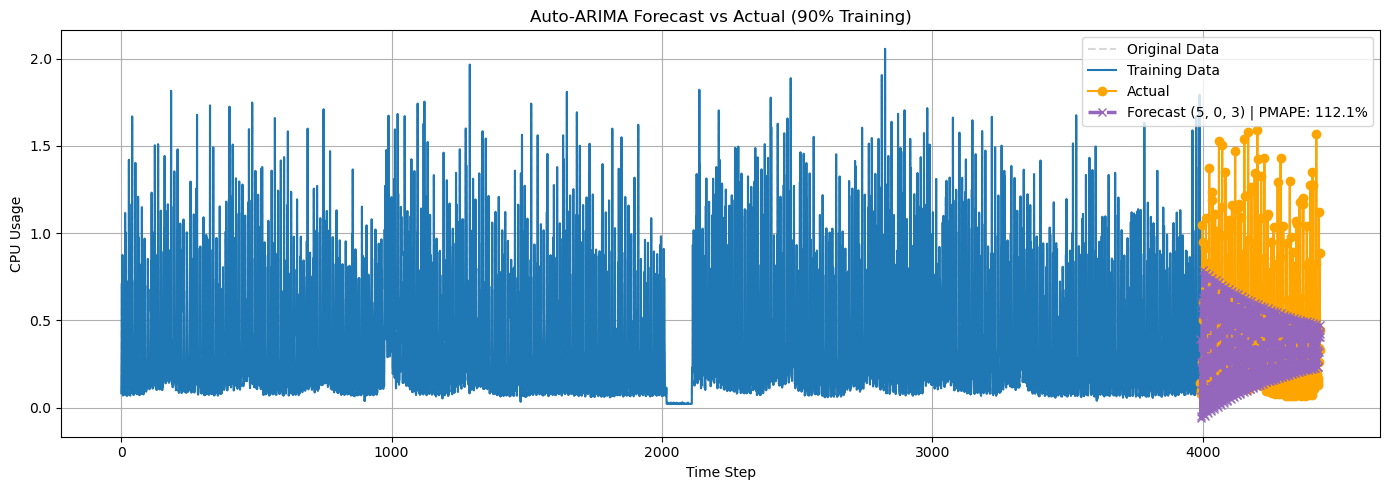


=== Forecast from 95% training ===
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3936.223, Time=1.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6387.584, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5219.589, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5788.691, Time=0.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3935.646, Time=1.69 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4898.124, Time=1.35 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3810.026, Time=6.76 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4116.953, Time=3.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4202.755, Time=1.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3748.588, Time=4.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3811.338, Time=1.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3805.173, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3536.717, Time=4.47 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3537.026, Time=0.93 s

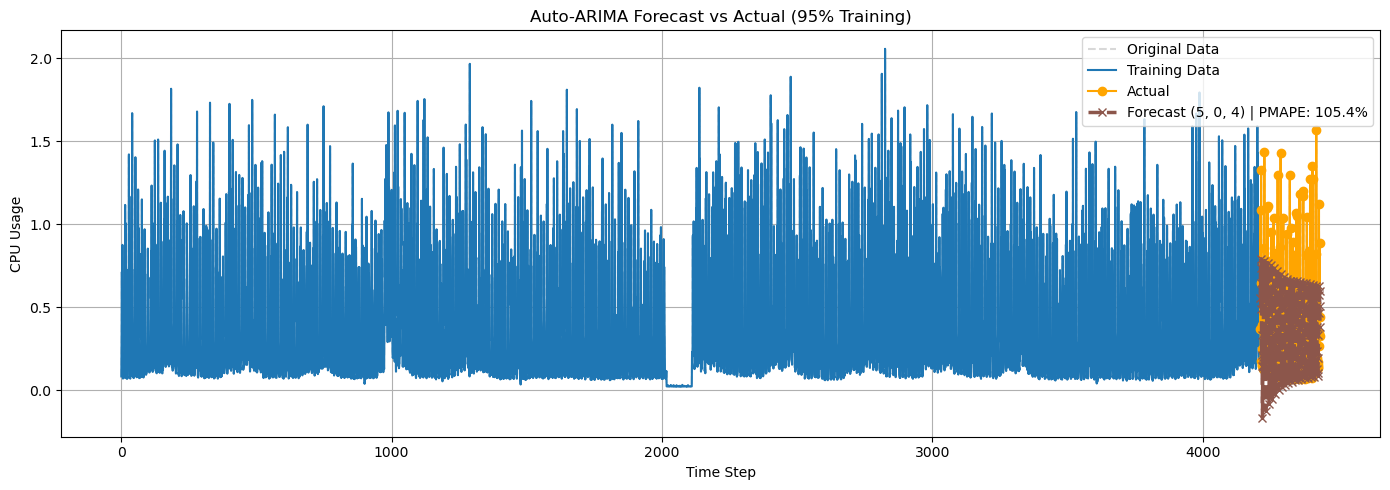

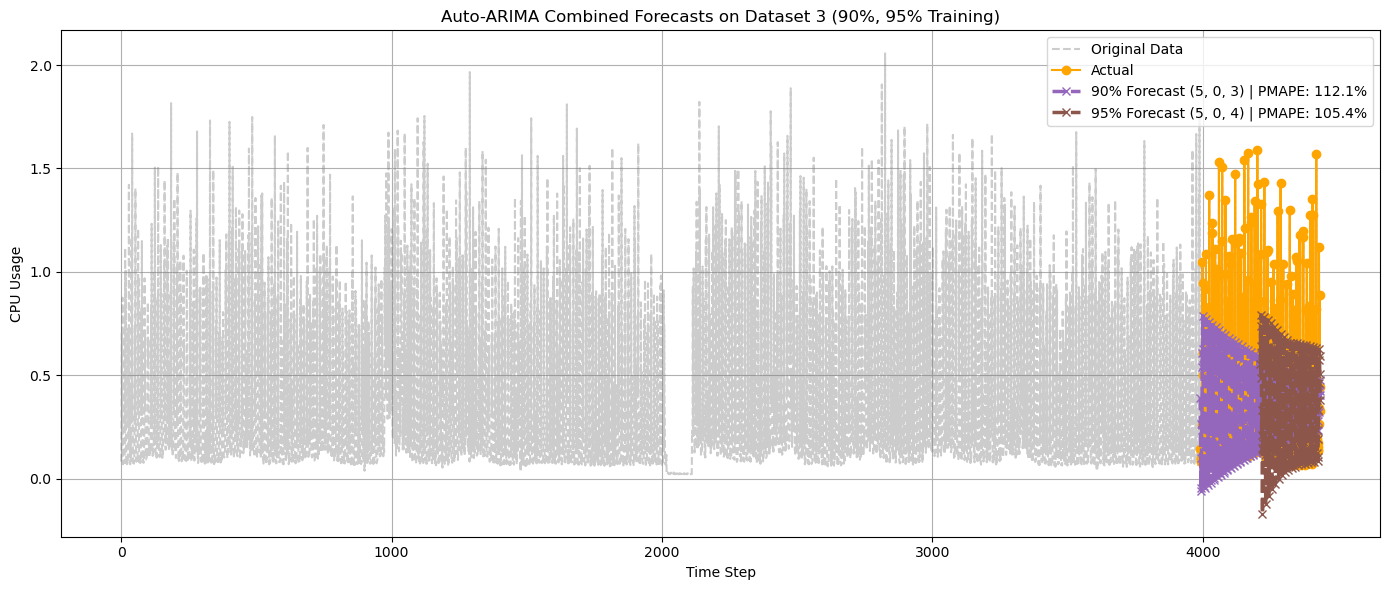

In [ ]:
#autoatima for 09 og 05%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

#  Load Dataset 3 (JSON) 
json_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/CPU-data-fra-github/data-jan-2022.json"
df = pd.read_json(json_path)
cpu_data = [float(value[1]) for value in df['result'][0]['values']]
cpu_series = np.array(cpu_data)

# Penalized MAPE 
def penalized_mape(y_true, y_pred, penalty=2.0):
    error = np.abs(y_true - y_pred)
    penalized_error = np.where(y_pred < y_true, error * penalty, error)
    return np.mean(penalized_error / np.maximum(np.abs(y_true), 1e-8)) * 100

# Training splits
splits = {
    0.9: 'tab:purple',
    0.95: 'tab:brown'
}

# Path to save individual plots
save_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/ARIMAMODELLER/Datset_1/Dataset3grafer"
os.makedirs(save_path, exist_ok=True)

# Store results for combined plot
combined_forecasts = {}

# Loop through each split
for split, color in splits.items():
    split_index = int(len(cpu_series) * split)
    train = cpu_series[:split_index]
    test = cpu_series[split_index:]

    print(f"\n=== Forecast from {int(split * 100)}% training ===")
    try:
        model = auto_arima(train,
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           error_action='ignore',
                           trace=True)

        fitted_model = model.fit(train)
        forecast = fitted_model.predict(n_periods=len(test))

        # Metrics
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        pmape = penalized_mape(test, forecast, penalty=2.0)

        print(f"Best ARIMA order: {model.order}")
        print(f"MAE:   {mae:.4f}")
        print(f"RMSE:  {rmse:.4f}")
        print(f"MAPE:  {mape:.2f}%")
        print(f"PMAPE: {pmape:.2f}%")

        # Save for combined plot
        combined_forecasts[split] = {
            'forecast': forecast,
            'split_index': split_index,
            'color': color,
            'pmape': pmape,
            'order': model.order
        }

        #INDIVIDUAL PLOT 
        plt.figure(figsize=(14, 5))
        plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.3)
        plt.plot(range(split_index), train, label="Training Data", color='tab:blue')
        plt.plot(range(split_index, len(cpu_series)), test, label="Actual", color='orange', marker='o')
        plt.plot(range(split_index, len(cpu_series)), forecast,
                 label=f"Forecast {model.order} | PMAPE: {pmape:.1f}%",
                 color=color, linestyle='--', linewidth=2.5, marker='x')

        plt.title(f"Auto-ARIMA Forecast vs Actual ({int(split * 100)}% Training)")
        plt.xlabel("Time Step")
        plt.ylabel("CPU Usage")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Save the plot
        filename = f"Dataset3_AutoARIMA_{int(split * 100)}_Training.png"
        plt.savefig(os.path.join(save_path, filename), dpi=300)
        plt.show()

    except Exception as e:
        print(f"❌ Forecast failed for {int(split * 100)}%: {e}")

# COMBINED PLOT (Only for show, no save)
plt.figure(figsize=(14, 6))
plt.plot(cpu_series, label="Original Data", color='gray', linestyle='--', alpha=0.4)

min_split = min([v['split_index'] for v in combined_forecasts.values()])
plt.plot(range(min_split, len(cpu_series)), cpu_series[min_split:], 
         label="Actual", color='orange', marker='o', linewidth=1.5)

for split, result in combined_forecasts.items():
    x_range = range(result['split_index'], result['split_index'] + len(result['forecast']))
    plt.plot(x_range, result['forecast'],
             label=f"{int(split*100)}% Forecast {result['order']} | PMAPE: {result['pmape']:.1f}%",
             color=result['color'], linestyle='--', linewidth=2.5, marker='x')

plt.title("Auto-ARIMA Combined Forecasts on Dataset 3 (90%, 95% Training)")
plt.xlabel("Time Step")
plt.ylabel("CPU Usage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
